In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

** Render matplotlib charts in the notebook **

In [184]:
%matplotlib inline

# Planet Bids Data Exploration

## Questions this analysis will address

1. Who are the vendors? What type of businesses bid?
2. Where are the vendors from?
3. Any trends in registration over time?

## Additional data & questions

Additional information as far as how many times a vendor has bidded, if they were awarded bids and when, etc. can only be answered if we ask the Planet Bids technical team for some data. 

## Import CSV file provided by Jason MacDonald

** Note that this is a sample file of 1k bidders. There are 17k+ total. **

In [185]:
pb = pd.read_csv('data/Planet_Bids_Vendors.csv')

In [186]:
pb.head()

,Company Name,FEI/TaxID Number,DBA,Address,City,State,Zip,Country,Contact,Email,Phone,Fax,Register Date,Business Type,Commodity Codes,Additional Desc,Comments
0,ddddddddddddd,252546586,ddddddddddd,dddddddddd dddddddddddd,dddddddddddd,Iowa,78241,United States,remove us please,pete@cox.net,949-555-1212 ext. 1,NaN,8/8/12,NaN,"16000-Professional, Scientific, Architectural,...",Veterinary Specialty practice,NaN
1,G&G Electric Inc.,10947473,NaN,4229 Giles Ct.,Riverside,California,92503,United States,Gilberto Chavez,chvz_glbrt@yahoo.com,951-572-0196,951-689-2694,12/20/13,NaN,"60000-Construction, Structures/Materials & Sup...",Electrical Subcontractors,NaN
2,"""A Quick Note""",556577390,A QUICK NOTE,P.O. Box 1275,Lake Forest,California,92609-1275,United States,Shannon Ziccardi,aquicknote.notary@gmail.com,949-279-6874,714-242-1789,3/13/14,NaN,"16000-Professional, Scientific, Architectural,...",Mobile Notary Public providing service to All ...,NaN
3,( iii ) DESIGN,201415592,NaN,811 El Captian Way Suite 130,San Luis Obispo,California,93401,United States,NaN,missy@iiidesign.com,805-595-1363 ext.,--,3/16/12,WBE,23000-Technology Hardware/Software and Services,"branding, print and web design studio that als...",NaN
4,"(W)right On Communications, Inc.",262211971,NaN,"674 Via de la Valle, Suite 300",Solana Beach,California,92075,United States,Chris Jensen,cjensen@wrightoncomm.com,503-459-6464,NaN,4/21/15,OSB,"16000-Professional, Scientific, Architectural,...",We're a full-spectrum communications agency sp...,NaN


## Cleanup 'Commodity Codes' and 'Business Type' columns

In [187]:
import re

In [188]:
def split_string_by(sep, x):
    return ''.join(s.strip() + '|' for s in re.split(sep, x) if s != '' and s != None)[:-1]
def split_commodity_codes(x):
    if type(x) is str:
        return split_string_by('\d*-', x)
def split_business_type(x):
    if type(x) is str:
        return split_string_by(',', x)

In [189]:
pb['Commodity Codes'] = pb['Commodity Codes'].apply(lambda x: split_commodity_codes(x))

In [190]:
pb['Business Type'] = pb['Business Type'].apply(lambda x: split_business_type(x))

## Get the year from Register Date

In [191]:
import datetime

In [192]:
def get_year_from_date(d):
    return datetime.datetime.strptime(d, '%m/%d/%y').date().year

In [193]:
pb['Register Year'] = pb['Register Date'].apply(lambda d: get_year_from_date(d))

## Turn blanks, none, and nulls into "Unknown" 

In [194]:
def sanitize_unknown(s):
    if type(s) is str and (s == None or s == '' or s.lower() == 'none'):
        s = s.strip()
        s = 'Unknown'
    return s

In [195]:
pb['Commodity Codes'] = pb['Commodity Codes'].apply(lambda c: sanitize_unknown(c))
pb['Business Type'] = pb['Business Type'].apply(lambda c: sanitize_unknown(c))

In [196]:
pb['Commodity Codes'] = pb['Commodity Codes'].fillna('Unknown')
pb['Business Type'] = pb['Business Type'].fillna('Unknown')

## Clean up city names!

We are cleaning these up since City names are entered inconsistently! Ugh.

In [197]:
def sanitize_city_name(c):
    new_city = c.lower()
    new_city = new_city.replace(',' , '')
    new_city = new_city.replace('ca' , '')
    new_city = new_city.replace('california' , '')
    new_city = new_city.strip()
    return new_city

In [198]:
pb['City'] = pb['City'].apply(lambda c: sanitize_city_name(c))

## Add a column to quickly filter vendors that are not in Long Beach

In [199]:
pb['In Long Beach?'] = pb['City'].apply(lambda c: c.lower() == 'long beach')

## Create new data frames for Commodity Codes and Business Type for manipulation

In [200]:
commodity_df = pb.copy(deep=True)

In [201]:
business_df = pb.copy(deep=True)

## Let's look at Commodity Codes

### Split Commodity Code into multiple rows

In [202]:
s = commodity_df['Commodity Codes'].str.split('|').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with dataframe's index
s.name = 'Commodity Codes' # needs a name to join

In [203]:
del commodity_df['Commodity Codes']
commodity_df = commodity_df.join(s)

### Reset the index of our dataframe as there are now duplicate indexes from the previous action

In [204]:
commodity_df = commodity_df.reset_index()

In [205]:
del commodity_df['index']

In [206]:
commodity_df.head(10)

,Company Name,FEI/TaxID Number,DBA,Address,City,State,Zip,Country,Contact,Email,Phone,Fax,Register Date,Business Type,Additional Desc,Comments,Register Year,In Long Beach?,Commodity Codes
0,ddddddddddddd,252546586,ddddddddddd,dddddddddd dddddddddddd,dddddddddddd,Iowa,78241,United States,remove us please,pete@cox.net,949-555-1212 ext. 1,NaN,8/8/12,Unknown,Veterinary Specialty practice,NaN,2012,False,"Professional, Scientific, Architectural, Techn..."
1,G&G Electric Inc.,10947473,NaN,4229 Giles Ct.,riverside,California,92503,United States,Gilberto Chavez,chvz_glbrt@yahoo.com,951-572-0196,951-689-2694,12/20/13,Unknown,Electrical Subcontractors,NaN,2013,False,"Construction, Structures/Materials & Supplies"
2,"""A Quick Note""",556577390,A QUICK NOTE,P.O. Box 1275,lake forest,California,92609-1275,United States,Shannon Ziccardi,aquicknote.notary@gmail.com,949-279-6874,714-242-1789,3/13/14,Unknown,Mobile Notary Public providing service to All ...,NaN,2014,False,"Professional, Scientific, Architectural, Techn..."
3,( iii ) DESIGN,201415592,NaN,811 El Captian Way Suite 130,san luis obispo,California,93401,United States,NaN,missy@iiidesign.com,805-595-1363 ext.,--,3/16/12,WBE,"branding, print and web design studio that als...",NaN,2012,False,Technology Hardware/Software and Services
4,"(W)right On Communications, Inc.",262211971,NaN,"674 Via de la Valle, Suite 300",solana beach,California,92075,United States,Chris Jensen,cjensen@wrightoncomm.com,503-459-6464,NaN,4/21/15,OSB,We're a full-spectrum communications agency sp...,NaN,2015,False,"Professional, Scientific, Architectural, Techn..."
5,"1 Plus One management, Inc",204924375,same,3622 Mount Vernon Drive suite 101,los angeles,California,90008,United States,jerrold smith,jerrold@1plusonemanagement.com,323-292-8404,323-292-6196,8/4/14,OSB|DBE|MBE,"Marketing, Advertising and Community Outreach ...",NaN,2014,False,"Office Supplies, Paper, Printing"
6,"1 Plus One management, Inc",204924375,same,3622 Mount Vernon Drive suite 101,los angeles,California,90008,United States,jerrold smith,jerrold@1plusonemanagement.com,323-292-8404,323-292-6196,8/4/14,OSB|DBE|MBE,"Marketing, Advertising and Community Outreach ...",NaN,2014,False,"Sporting, Arts, Music Products and Services"
7,1 Stop Pool Supply,454674838,1 Stop Pool Supply,26479 Rancho Parkway S.,lake forest,California,92630,United States,Joseph Delzingaro,joe@1stioppoolsupply.com,866-384-7665,NaN,9/19/13,Unknown,Supplier of swimming pool and related products...,NaN,2013,False,Safety Equipment and Supplies
8,1 Stop Pool Supply,454674838,1 Stop Pool Supply,26479 Rancho Parkway S.,lake forest,California,92630,United States,Joseph Delzingaro,joe@1stioppoolsupply.com,866-384-7665,NaN,9/19/13,Unknown,Supplier of swimming pool and related products...,NaN,2013,False,"Sporting, Arts, Music Products and Services"
9,1 Stop Pool Supply,454674838,1 Stop Pool Supply,26479 Rancho Parkway S.,lake forest,California,92630,United States,Joseph Delzingaro,joe@1stioppoolsupply.com,866-384-7665,NaN,9/19/13,Unknown,Supplier of swimming pool and related products...,NaN,2013,False,"Chemicals (All Products, Services, incl testing)"


## What do the Commodity Codes look like?

In [207]:
commodity_codes_count = commodity_df['Commodity Codes'].value_counts()
commodity_codes_keys = commodity_df['Commodity Codes'].value_counts().keys()

### Plot Commodity Codes count distribution

In [208]:
commodity_codes_count

Unknown                                                            347
Construction, Structures/Materials & Supplies                      194
Professional, Scientific, Architectural, Technical Services        173
Technology Hardware/Software and Services                          119
Civil Engineering Construction / Materials                          91
Building Maintenance, Janitorial                                    74
Homeland Security Products and Services                             72
Safety Equipment and Supplies                                       69
Office Supplies, Paper, Printing                                    57
Landscaping and Gardening Products and Services                     39
Transportation Services                                             36
Rental and Lease Services                                           34
Automotive Parts, Services                                          32
Sporting, Arts, Music Products and Services                         32
Furnit

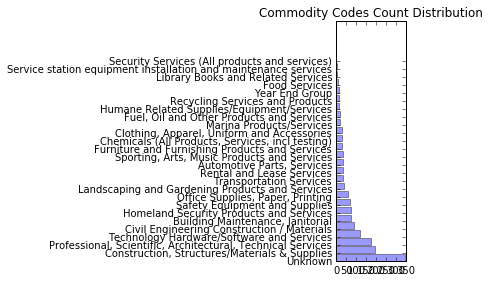

In [209]:
y_pos = np.arange(len(commodity_codes_keys))

plt.barh(y_pos, commodity_codes_count, alpha=0.4)
plt.yticks(y_pos, commodity_codes_keys)
plt.title('Commodity Codes Count Distribution')
plt.tight_layout()

plt.show()

## What do the Business Types look like?

Let's do some cleanup first...

In [210]:
# Split Business Type column values into multiple rows
s = business_df['Business Type'].str.split('|').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with dataframe's index
s.name = 'Business Type' # needs a name to join

# Update Dataframe
del business_df['Business Type']
business_df = business_df.join(s)

# Reset Dataframe's index
business_df = business_df.reset_index()
del business_df['index']

### Plot Business Type count distribution

In [211]:
business_type_count = business_df['Business Type'].value_counts()
business_type_keys = business_df['Business Type'].value_counts().keys()

In [212]:
business_type_count

Unknown    512
LBSBE      230
OSB        199
MBE        178
WBE        128
FSB         63
DBE         51
MIC         24
HUD         13
LOC         11
NAP          8
NON          1
BLA          1
DVB          1
Name: Business Type, dtype: int64

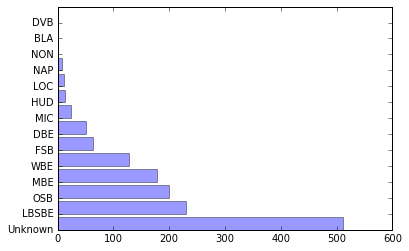

In [213]:
y_pos = np.arange(len(business_type_keys))

plt.barh(y_pos, business_type_count, alpha=0.4)
plt.yticks(y_pos, business_type_keys)

plt.show()

## Where are the vendors from?

In [214]:
zip_code_count = pb['Zip'].value_counts()
zip_code_keys = pb['Zip'].value_counts().keys()

In [215]:
zip_code_count

90807         21
90813         17
90755         14
90670         12
90802         12
92806          9
92618          9
92647          8
90640          7
90248          7
90071          7
90805          7
90720          6
90808          6
92821          6
91352          5
92660          5
92705          5
90815          5
92841          5
92801          5
90706          5
90502          5
90245          5
92867          5
92614          5
92011          4
92870          4
90630          4
91762          4
              ..
95630          1
85009          1
90802-3037     1
95361          1
60515          1
90501-3601     1
92120          1
95811          1
91763          1
8873           1
92841-4166     1
95841-7816     1
18966          1
11101          1
90831          1
94115-5555     1
92081          1
92869          1
90734          1
10591          1
3844           1
90731          1
90048          1
91304          1
48152          1
92427          1
33549          1
93291-9525    

## Any trends in vendor registration over time?

See external charts.

## Export data

In [216]:
pb.to_csv("exports/planet-bids-all.csv")
commodity_df.to_csv("exports/planet-bids-commodity.csv")
business_df.to_csv("exports/planet-bids-business.csv")

## Sanity Check


In [217]:
print 'The original data frame has ' + str(len(pb)) + ' rows.'

The original data frame has 1000 rows.


How many Long Beach vendors identify themeselves by Commodity Code?

In [218]:
len(commodity_df[commodity_df['In Long Beach?'] == True])

132

Versus everyone outside the City?

In [219]:
len(commodity_df[commodity_df['In Long Beach?'] == False])

1427